# 03 PCE Model Training

## General Notebook Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')  # nopep8

import os
import time 
import pickle

import numpy as np
import pandas as pd
from statistics import mean

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import chaospy as cp
from UQpy.surrogates import *

from helper_functions import setup_plot, optimize_facetgrid_titles, fit_regression_lasso_cv, get_joint

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

sns.set_theme(style="whitegrid", palette="bright")
bright_palette = sns.color_palette("bright")

## Functions

### Data Selection

In [3]:
def load_sim_data(ipath, case_matrix, case_data):
    """
    Load and combine simulation data from case matrix and case data files.

    Args:
        ipath (str): Directory path to the data files.
        case_matrix (str): Filename of the case matrix CSV file.
        case_data (str): Filename of the case data CSV file.

    Returns:
        pandas.DataFrame: Combined DataFrame of cases and case data.
    """
    case_matrix_path = os.path.join(ipath, case_matrix)
    case_data_path = os.path.join(ipath, case_data)
    cases = pd.read_csv(case_matrix_path)
    case_data = pd.read_csv(case_data_path).sort_values(
        by=['Case']).reset_index(drop=True)
    return pd.concat([cases, case_data], axis=1)

def get_training_data(data, num_samples, num_replications, target, moment='mean'):
    """
    Retrieves a subset of training data with specified samples and replications, and computes the
    mean or standard deviation for the target variable based on the specified moment.

    Args:
        data (DataFrame): The complete dataset from which to extract training data.
        num_samples (int): The number of unique samples to retrieve.
        num_replications (int): The number of replications for each unique sample.
        target (str): The target variable to predict.
        moment (str, optional): The statistical moment to compute for the target variable over its replications.
                                Accepts 'mean' or 'sdv' (standard deviation). Defaults to 'mean'.

    Returns:
        numpy.ndarray: The feature matrix for training, with each unique sample's features replicated.
        numpy.ndarray: The feature matrix after applying the forward transformation from the joint distribution.
        pandas.Series: The target variable, aggregated by the specified moment across its replications.
    """

    target_mapping = {
        'Tower_Sdv': 'TwHtALxt_[m/s^]_sdv',
        'Tower_Max': 'TwHtALxt_[m/s^]_max',
        'Blade_Mean': 'RootMyb_[kN-m]_mean',
        'Blade_Max': 'RootMyb_[kN-m]_max'
    }
    target = target_mapping.get(target, None)
    filtered_df = pd.DataFrame()
    unique_samples = data.iloc[0:num_samples, 0:4]

    for i in range(len(unique_samples)):
        # Calculate the starting and ending row indices for each feature combination
        idx_list = [i+j*300 for j in range(num_replications)]
        temp_df = data.iloc[idx_list, :]
        # Append the extracted rows to the filtered DataFrame
        filtered_df = pd.concat([filtered_df, temp_df])
    clean_df = filtered_df.dropna(how='any', axis=0)

    if len(filtered_df) - len(clean_df) == 0:
        pass
    else:
        print(
            f"{len(filtered_df) - len(clean_df)} rows were removed from the training data")

    if num_replications > 1:
        if moment == 'mean':
            clean_df = clean_df.groupby(list(clean_df.columns[0:4]))[
                target].mean().reset_index()
        elif moment == 'sdv':
            clean_df = clean_df.groupby(list(clean_df.columns[0:4]))[
                target].std().reset_index()

    x_train = clean_df.iloc[:, 0:4]
    y_train = clean_df.loc[:, target]
    distribution = get_joint(input_path_scada)
    x_train = np.array(x_train).T
    x_train_uniform = distribution.fwd(x_train)

    return x_train.T, x_train_uniform.T, y_train

def get_validation_data(data, target, moment='mean'):
    """
    Processes the validation data by grouping it according to feature combinations and computing the
    specified statistical moment (mean or standard deviation) of the target variable.

    Args:
        data (DataFrame): The dataset from which to extract validation data.
        target (str): The name of the target variable in the dataset.
        moment (str, optional): The statistical moment to compute for the target variable over its replications.
                                Accepts 'mean' for mean value or 'sdv' for standard deviation. Defaults to 'mean'.

    Returns:
        numpy.ndarray: The feature matrix for validation, with each unique sample's features.
        numpy.ndarray: The feature matrix after applying the forward transformation from the joint distribution.
        pandas.Series or numpy.ndarray: The aggregated target variable using the specified statistical moment.
    """

    target_mapping = {
        'Tower_Sdv': 'TwHtALxt_[m/s^]_sdv',
        'Tower_Max': 'TwHtALxt_[m/s^]_max',
        'Blade_Mean': 'RootMyb_[kN-m]_mean',
        'Blade_Max': 'RootMyb_[kN-m]_max'
    }
    target = target_mapping.get(target, None)

    if moment == 'mean':
        val_data = data.groupby(list(data.columns[0:4]))[
            target].mean().reset_index()
    elif moment == 'sdv':
        val_data = data.groupby(list(data.columns[0:4]))[
            target].std().reset_index()

    x_val = val_data.iloc[:, 0:4]
    y_val = val_data.loc[:, target]
    distribution = get_joint(input_path_scada)
    x_val = np.array(x_val).T
    x_val_uniform = distribution.fwd(x_val)

    return x_val.T, x_val_uniform.T, y_val

### Model Training & Validation

In [4]:
def custom_scorer(y_true, y_pred):
    """
    Calculate normalized root mean squared error (nRMSE), normalized mean absolute error (nMAE),
    and mean absolute error (MAE) between true and predicted values.

    The function normalizes the RMSE and MAE by the mean of the true values to account for scale variations
    and allow for comparison across different datasets.

    Args:
        y_true (array-like): True target values.
        y_pred (array-like): Predicted target values.

    Returns:
        dict: A dictionary containing the following metrics:
            - nRMSE (float): Normalized root mean squared error.
            - nMAE (float): Normalized mean absolute error.
            - MAE (float): Mean absolute error.
    """
    # Calculate the mean of the true values
    true_mean = np.mean(y_true)

    # Calculate mean squared error and normalize it
    rmse = mean_squared_error(y_true, y_pred)
    nrmse = np.sqrt(rmse) / true_mean

    # Calculate mean absolute error and normalize it
    mae = mean_absolute_error(y_true, y_pred)
    nmae = mae / true_mean
    # return {'nRMSE': nrmse, 'nMAE': nmae, 'MAE': mae, 'R2': r2}
    # return {'nRMSE': nrmse, 'nMAE': nmae, 'MAE': mae}
    return {'nRMSE': nrmse, 'nMAE': nmae}

def built_pce(x_train_uniform, y_train, poly_order, regressor):
    """
    Constructs a Polynomial Chaos Expansion (PCE) model using the specified regression technique.

    Args:
        x_train_uniform (numpy.ndarray): The input feature matrix after applying a uniform transformation.
        y_train (numpy.ndarray): The target values corresponding to the input features.
        poly_order (int): The order of the polynomial for the PCE model.
        regressor (str): The regression method to use for constructing the PCE model. 
                         Acceptable values are 'lasso_cv' for Lasso regression with cross-validation,
                         or 'least_square' for least squares regression.

    Returns:
        model_approx: The constructed PCE model.
        alpha_cv_df: The dataframe containing alpha values if 'lasso_cv' is used; otherwise None.
        final_alpha: The final alpha value if 'lasso_cv' is used; otherwise None.
        elapsed_time (float): The time taken to construct the model in seconds.

    Raises:
        ValueError: If the regressor argument is not one of the accepted values.
    """

    if regressor not in ['lasso_cv', 'least_square']:
        raise ValueError(
            "Regressor must be either 'lasso_cv' or 'least_square'.")

    distribution_uniform = cp.J(cp.Uniform(0, 1), cp.Uniform(
        0, 1), cp.Uniform(0, 1), cp.Uniform(0, 1))

    expansion = cp.generate_expansion(poly_order, distribution_uniform)

    start_time = time.time()

    if regressor == 'lasso_cv':
        model_approx, alpha_cv_df, final_alpha = fit_regression_lasso_cv(
            expansion, x_train_uniform.T, y_train, retall=3)
    elif regressor == 'least_square':
        model_approx = cp.fit_regression(
            expansion, x_train_uniform.T, y_train, retall=0)
        alpha_cv_df = None
        final_alpha = None

    elapsed_time = time.time() - start_time
    return model_approx, alpha_cv_df, final_alpha, elapsed_time

def convergence_analysis_val(target, moment, poly_order_range, regressor, num_samples_range, num_replications, df_train, df_test):
    """
    Performs a convergence analysis using cross-validation for a range of polynomial orders and sample sizes.
    The analysis is done for a specific target variable and moment ('mean' or 'sdv').

    Args:
        target (str): The target variable for which the convergence analysis is being performed.
        moment (str): The moment for the analysis ('mean' or 'sdv').
        poly_order_range (tuple): A range (start, stop, step) of polynomial orders to evaluate.
        regressor (str): The regression method to use ('lasso_cv' or 'least_square').
        num_samples_range (tuple): A range (start, stop, step) of sample sizes to evaluate.
        num_replications (int): The number of replications of each unique sample.
        df_train (DataFrame): The DataFrame containing the training data.

    Returns:
        DataFrame: A DataFrame containing the timing data for each combination of polynomial order and sample size.
        DataFrame: A DataFrame containing the cross-validation scores for each metric, for each combination of 
                    polynomial order and sample size.
    """

    timing_data = []
    scores_data = []
    for poly_order in np.arange(*poly_order_range):
        for num_samples in np.arange(*num_samples_range):

            _, x_train_uniform, y_train = get_training_data(
                df_train, num_samples, num_replications, target, moment)

            pce, _, _, elapsed_time = built_pce(
                x_train_uniform, y_train, poly_order, regressor)

            scores = validate_pce(pce, df_test, target, moment)

            # Record the timing data
            timing_data.append({
                'Num_Samples': num_samples,
                'Num_Replications': num_replications,
                'Polynomial Order': poly_order,
                'Time (s)': elapsed_time
            })

            for metric in scores.keys():
                scores_data.append({
                    'Num_Samples': num_samples,
                    'Num_Replications': num_replications,
                    'Metric': metric,
                    'Polynomial Order': poly_order,
                    'Score': scores[metric]
                })
            if not check_polynomial(pce, target, moment):
                print(f"Warning: {moment} model for {target} (Order {poly_order}, {num_samples} samples) fitted as constant value {str(pce)}")
            #else:
            #    print('no issue')
            

    # Convert lists of dictionaries to DataFrames
    df_timing = pd.DataFrame(timing_data)
    df_scores = pd.DataFrame(scores_data)

    return df_timing, df_scores

def validate_pce(pce, df_test, target, moment):
    """
    Validates a Polynomial Chaos Expansion (PCE) model against a testing dataset and calculates performance metrics.

    Args:
        pce: The PCE model to validate. This should be a fitted model capable of making predictions.
        df_test (DataFrame): The DataFrame containing the test data.
        target (str): The target variable name in the test DataFrame.
        moment (str): The statistical moment to consider for the target variable during validation ('mean' or 'sdv').

    Returns:
        dict: A dictionary of performance metrics calculated using the custom scorer function. This typically includes
            normalized root mean squared error (nRMSE) and normalized mean absolute error (nMAE).

    The function retrieves the testing features and target values, makes predictions using the PCE model, and then
    calculates performance metrics using the custom scorer function. It returns these metrics to assess the model's
    performance.
    """
    
    _, x_val_uniform, y_val = get_validation_data(
        df_test, target, moment)
    # Use the custom function to predict the output
    y_pred = eval_pce(pce, x_val_uniform[:, 0],
                    x_val_uniform[:, 1], x_val_uniform[:, 2], x_val_uniform[:, 3])

    scores = custom_scorer(y_val, y_pred)

    return scores

def eval_pce(model_approx, q0, q1, q2, q3):
    """
    Evaluate the Polynomial Chaos Expansion (PCE) model approximation for given parameter values.

    Args:
        model_approx: The PCE model approximation object from chaospy library.
        q0 (array-like): Values for the first input parameter of the PCE model.
        q1 (array-like): Values for the second input parameter of the PCE model.
        q2 (array-like): Values for the third input parameter of the PCE model.
        q3 (array-like): Values for the fourth input parameter of the PCE model.

    Returns:
        numpy.ndarray: The evaluated values of the PCE model for the provided parameters.
    """
    if any([i in str(model_approx) for i in ['q0', 'q1', 'q2', 'q3']]):
        return eval(str(model_approx), {'q0': q0, 'q1': q1, 'q2': q2, 'q3': q3})
    else:
        return np.array([eval(str(model_approx)) for _ in range(len(q0))])

def check_polynomial(model_approx, target, moment):
    """
    Check if the Polynomial Chaos Expansion (PCE) model approximation from chaospy represents a constant polynomial,
    and issue a warning if it does.

    Args:
        model_approx: The PCE model approximation object from chaospy library.
        target (str): The name of the target variable the model is approximating.
        moment (str): The statistical moment ('mean' or 'standard deviation') represented by the model.

    This function prints a warning message if the model approximation does not include any of the 
    input parameter terms ('q0', 'q1', 'q2', 'q3'), indicating that it may be a constant polynomial.
    """
    if not any([i in str(model_approx) for i in ['q0', 'q1', 'q2', 'q3']]):
        return False
    else:
        return True


### Plotting

In [5]:
def plot_heatmaps_facetgrid(df_train, target, get_training_data, setup_plot, log=False):
    mappable = []
    def get_combined_data(sample_size, moments):
        combined_data = pd.DataFrame()
        for moment in moments:
            x_train, _, y_train = get_training_data(df_train, sample_size, 30, target, moment=moment)
            df = pd.DataFrame(x_train, columns=['Wind Speed', 'Turbulence Intensity', 'Air Density', 'Yaw Misalignment'])
            df[target] = y_train
            df['Moment'] = moment.title()
            # Keep 'Wind Speed' separate and melt the other features
            melted = df.melt(id_vars=['Wind Speed', target, 'Moment'], var_name='Feature', value_name='Value')
            combined_data = pd.concat([combined_data, melted])
        return combined_data

    def plot_contours(data, **kwargs):
        ax = plt.gca()
        # Ensure data is sorted or use a scatter plot to map x, y, and z
        x = data['Wind Speed']
        y = data['Value']
        z = data[target]
        if not log:
            ax.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
            cntr = ax.tricontourf(x, y, z, levels=14, cmap=sns.diverging_palette(230, 20, as_cmap=True))
            ax.plot(x, y, 'ko', ms=1)
        else:
            norm = plt.colors.LogNorm(vmin=y.min(), vmax=y.max())
            cntr = ax.scatter(x, y, c='k', cmap='viridis', norm=norm, edgecolor='k')
        mappable.append(cntr)  # Store the ScalarMappable object
        return cntr

    # Data preparation
    moments = ['mean', 'sdv']
    features = ['Wind Speed', 'Turbulence Intensity', 'Air Density', 'Yaw Misalignment']
    combined_data = get_combined_data(300, moments)

    # Create the FacetGrid
    FIG_WIDTH, FIG_HEIGHT = setup_plot(.7)
    FIG_WIDTH, FIG_HEIGHT = FIG_WIDTH, FIG_HEIGHT*1.2
    sub_height = FIG_HEIGHT/2
    sub_width = FIG_WIDTH/3
    mapping_dict = {
        'Mean': '$\mu$',
        'Sdv': '$\sigma$'
        }
    combined_data['Moment'] = combined_data['Moment'].map(mapping_dict)

    g = sns.FacetGrid(combined_data, row='Moment', col='Feature', sharey=False, sharex='col',
                    margin_titles=True, height=sub_height,  aspect=sub_width / sub_height)

    # Apply the plotting function to each subplot in the grid
    g.map_dataframe(plot_contours)
    g = optimize_facetgrid_titles(g)
    features = ['Turbulence Intensity [-]', 'Air Density [kg/$m^3$]', 'Yaw Misalignment Angle [°]']
    moments = ['mean', 'sdv']

    for i, moment in enumerate(moments):
        for j, feature in enumerate(features):
            ax = g.facet_axis(i, j)  # Offset by 1 due to 'Wind Speed' being a separate column
            ax.set_ylabel(feature)
            if moment=='sdv':
                ax.set_xlabel('Wind Speed [m/s]')

    g.set_titles(col_template="", row_template="{row_name}")
    g.fig.subplots_adjust(hspace=.5, wspace=0.4, bottom=0.25)
    num_cols = 3  # Assuming there are 3 features + 1 for Wind Speed
    for row, moment in enumerate(moments):
        # Calculate bottom position for the colorbar axes
        if moment=='mean':
            bottom = g.axes[row, 0].get_position().ymin - 0.04  # Adjust this as needed
        else:
            bottom = g.axes[row, 0].get_position().ymin - 0.12
        left = .25
        width = (g.axes[row, 0].get_position().width * num_cols)*0.8
        height = 0.015  # Adjust height to match your preference

        # Create an axis for the colorbar below each row
        cbar_ax = g.fig.add_axes([left, bottom, width, height])
        # Use the first ScalarMappable of each row for the colorbar
        if moment=='mean':
            plt.colorbar(mappable=mappable[row * num_cols], cax=cbar_ax, orientation='horizontal', label='Mean Blade Loads [kNm]')
        else:
            plt.colorbar(mappable=mappable[row * num_cols], cax=cbar_ax, orientation='horizontal', label='Mean Blade Loads [kNm]')

    #store_plot(g, 'surface.png')
    
def create_custom_grid(df_least_squares, df_lasso, target_name):
    """
    Creates a custom grid of subplots for different regression methods (Least Squares and Lasso) 
    stratified by metric and moment, combined into a single dataframe.
    Args:
        df_least_squares (DataFrame): DataFrame containing data for the least squares regression method.
        df_lasso (DataFrame): DataFrame containing data for the Lasso regression method.
        target_name (str): The name of the target variable.
    """
    
    df_least_squares['Method'] = 'Least Squares'
    df_lasso['Method'] = 'LASSO'
    mapping_dict = {
        'mean': '$\mu$',
        'sdv': '$\sigma$'
        }

    df_combined = pd.concat([df_least_squares, df_lasso])

    df_combined['Method-Metric'] = df_combined['Method'] + ' - ' + df_combined['Metric']

    method_metric_order = ['Least Squares - ' + met for met in df_least_squares['Metric'].unique()] + \
                            ['LASSO - ' + met for met in df_lasso['Metric'].unique()]
    df_combined['Method-Metric'] = pd.Categorical(df_combined['Method-Metric'], 
                                                categories=method_metric_order, 
                                                ordered=True)
    df_combined.sort_values('Method-Metric', inplace=True)

    FIG_WIDTH, FIG_HEIGHT = setup_plot(.6)
    sub_height = FIG_HEIGHT/2
    sub_width = FIG_WIDTH/4

    df_combined_cp = df_combined.copy()
    df_combined_cp.Moment = df_combined_cp['Moment'].map(mapping_dict)#df_combined_cp.Moment.str.capitalize()

    g = sns.FacetGrid(df_combined_cp, col="Method-Metric", row="Moment", hue="Polynomial Order", 
                    sharey=False, margin_titles=True, height=sub_height, aspect=sub_width /sub_height)
    
    g.map_dataframe(sns.lineplot, "Num_Samples", "Score", marker='o')

    g.set_axis_labels("Number of Samples", "Score [-]")
    g.set_titles(row_template="{row_name}", col_template="{col_name}")
    g = optimize_facetgrid_titles(g, row_pre="")

    g.add_legend(title="Polynomial Order", bbox_to_anchor=(.5, -0.1), ncol=5, frameon=False)
    #store_plot(g, f"PCE_conv_plot_{target_name}.png")

### Helper

In [6]:
def merge_moments(df_mean, df_sdv):
    """
    Merges two DataFrames containing the results for mean and standard deviation moments into a single DataFrame.

    Args:
        df_mean (DataFrame): A DataFrame containing the convergence analysis results for the mean moment.
        df_sdv (DataFrame): A DataFrame containing the convergence analysis results for the standard deviation moment.

    Returns:
        DataFrame: A concatenated DataFrame with results for both mean and standard deviation moments,
                with an additional column indicating the 'Moment'.
    """

    df_mean['Moment'] = 'mean'
    df_sdv['Moment'] = 'sdv'
    return pd.concat([df_mean, df_sdv])

def convergence_wrapper(target, poly_order_range, regressor, sample_range, num_replications, strat, df_train, df_test=None):
    """
    Runs the convergence analysis for a given target using specified parameters and returns the combined results
    for mean and standard deviation moments.

    Args:
        target (str): The target variable for the convergence analysis.
        poly_order_range (tuple): A tuple specifying the range of polynomial orders to test.
        regressor (str): The type of regression model to use for analysis.
        sample_range (tuple): A tuple specifying the range of sample sizes to test.
        num_replications (int): The number of times to replicate each sample for the analysis.
        strat (str): Strategy to use for analysis; 'cv' for cross-validation or 'val' for validation.
        df_train (DataFrame): The training dataset.
        df_test (DataFrame, optional): The testing dataset. Only required if 'strat' is 'val'.

    Returns:
        DataFrame: A DataFrame with the combined results of convergence analysis for both mean and standard deviation moments.

    Raises:
        ValueError: If the provided strategy is not one of 'cv' or 'val'.
    """

    if strat not in ['cv', 'val']:
        raise ValueError("Strategy must be either 'cv' or 'val'.")
    if strat == 'cv':
        # This is no longer in use
        _, scoring_df_mean = convergence_analysis_cv(target, "mean", poly_order_range, regressor,
                                                                sample_range, num_replications, df_train)
        _, scoring_df_sdv = convergence_analysis_cv(target, "sdv", poly_order_range, regressor,
                                                                sample_range, num_replications, df_train)
    elif strat == 'val':
        _, scoring_df_mean = convergence_analysis_val(target, "mean", poly_order_range, regressor,
                                                                sample_range, num_replications, df_train, df_test)
        _, scoring_df_sdv = convergence_analysis_val(target, "sdv", poly_order_range, regressor,
                                                                sample_range, num_replications, df_train, df_test)
    return merge_moments(scoring_df_mean, scoring_df_sdv)

def display_scores_table(scores_dict):
    """
    Creates a table from the scores dictionary and prints it.

    Args:
        scores_dict (dict): A nested dictionary where the first key is the target,
                            the second key is the moment ('mean' or 'sdv'),
                            and the value is another dictionary with metric names and their corresponding scores.

    Returns:
        DataFrame: A pandas DataFrame representing the scores table for display.
    """
    score_rows = []

    for target, moments in scores_dict.items():
        for moment, metrics in moments.items():
            for metric, value in metrics.items():
                score_rows.append({
                    'Target': target,
                    'Moment': moment,
                    'Metric': metric,
                    'Value': value.round(2)
                })

    scores_df = pd.DataFrame(score_rows)

    scores_pivot = scores_df.pivot_table(
        index=['Target', 'Moment'], columns='Metric', values='Value', aggfunc='first')

    scores_pivot.reset_index(inplace=True)

    return scores_pivot

def store_models(model_dict):
    """
    Serializes and stores a dictionary of models to a pickle file.

    This function takes a dictionary containing models, serializes it using Python's pickle module,
    and writes it to a file named 'pce_models.pickle' located in the 'models' directory. 

    Args:
        model_dict (dict): A dictionary where keys are model identifiers and values are model objects.

    Returns:
        None: This function does not return any value. It saves the serialized object to a file.

    Raises:
        IOError: If the function cannot write to the specified file location.
        PicklingError: If an error occurs during the serialization process.
    """
    os.makedirs('models', exist_ok=True)
        
    with open(os.path.join(os.path.dirname(os.getcwd()), r"data\models\pce_models.pickle"), 'wb') as handle:        
        pickle.dump(model_dict, handle)

## Model Convergence
Here the model convergence is analysed, comparing model fit with varying amounts of training and regressor. Here, we test the least-squares and LASSO method. In the case of the LASSO regressor, the regularization coefficient is found using 10-fold cross validation. The PCE models are implemented using the Chaospy package.

Model fit is evaluated on the validation set using the normalized MAE and RMSE defined as follows:
$$\text{nMAE} = \frac{1}{N \cdot \bar{y}} \sum_{i=1}^{N} |y_i - \hat{y}_i|,$$

$$\text{nRMSE} = \frac{\sqrt{\frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2}}{\bar{y}}.$$
Here, $y_i$ is the true value, $\hat{y}_i$ is the predicted value, $N$ is the number of data points, and $\bar{y}$ is the mean of the true values.


### Initial Setup

In [7]:
input_path_sim = os.path.join(os.path.dirname(os.getcwd()), r"data\simulation")
input_path_scada = os.path.join(os.path.dirname(os.getcwd()), r"data\scada")

df = load_sim_data(input_path_sim, 'casematrix.csv', 'surrogate_data.csv')
df_train = df.iloc[0:9000, :]
df_test = df.iloc[9000:, :]
dict_full_scores_sq = {}
dict_full_scores_la = {}
sample_range = (50, 300+1, 50)
num_replications = 30
poly_order_range = (1, 5+1, 1)

### Blade Loads

First the model fits are plotted for the mean ($M_\text{blade,mean}$) and maximum ($M_\text{blade,max}$) flapwise bending moments at the blade root. Hereby, $\mu$ will represent the mean response over the seed-to-seed uncertainty while $\sigma$ is the corresponding standard deviation.

#### PCE - $M_\text{blade,mean}$

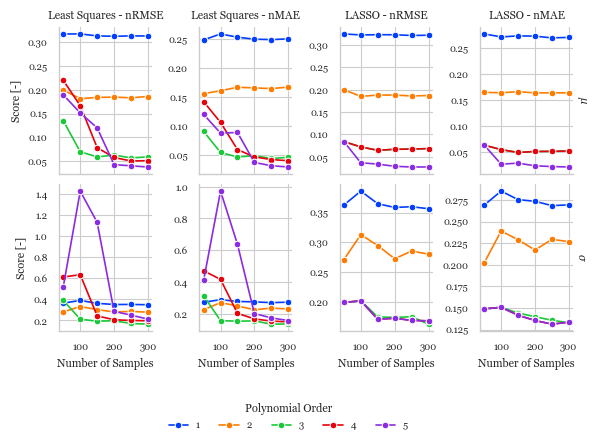

In [8]:
target = "Blade_Mean"
dict_full_scores_la[target] = convergence_wrapper(target, poly_order_range, 'lasso_cv',
                                                sample_range, num_replications, 'val', df_train, df_test)
dict_full_scores_sq[target] = convergence_wrapper(target, poly_order_range, 'least_square',
                                                sample_range, num_replications, 'val', df_train, df_test)
create_custom_grid(dict_full_scores_sq[target], dict_full_scores_la[target], target)

To help understand the difficulties in archieving good model fit for the standard deviation models, the response surfaces are visualized for this target.

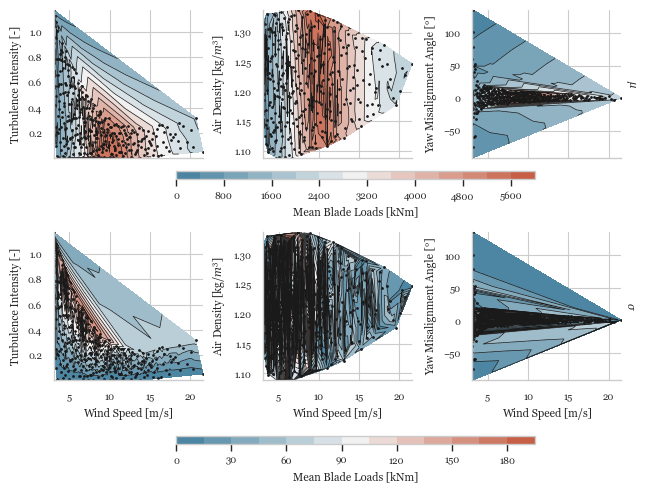

In [9]:
target = "Blade_Mean"
plot_heatmaps_facetgrid(df_train, target, get_training_data, setup_plot, log=False)

#### PCE - $M_\text{blade,max}$

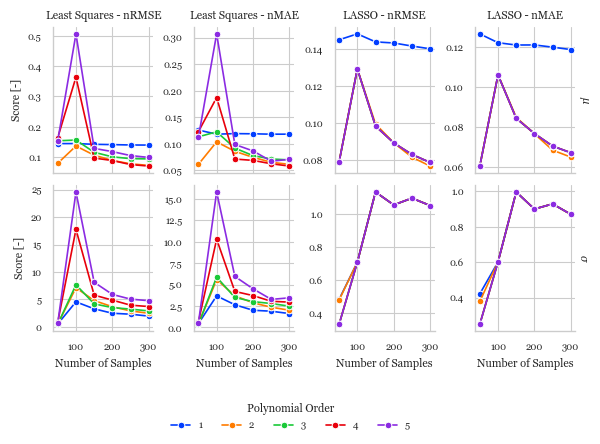

In [10]:
target = "Blade_Max"
dict_full_scores_la[target] = convergence_wrapper(target, poly_order_range, 'lasso_cv',
                                                   sample_range, num_replications, 'val', df_train, df_test)
dict_full_scores_sq[target] = convergence_wrapper(target, poly_order_range, 'least_square',
                                                   sample_range, num_replications, 'val', df_train, df_test)
create_custom_grid(dict_full_scores_sq[target], dict_full_scores_la[target], target)

### Tower Acceleration

Next, model fits are explored for the standard ($\ddot{x}_\text{tower,std}$) deviation and maximum ($\ddot{x}_\text{tower,max}$) tower-top acceleration in the fore-aft direction.

#### PCE - $\ddot{x}_\text{tower,std}$

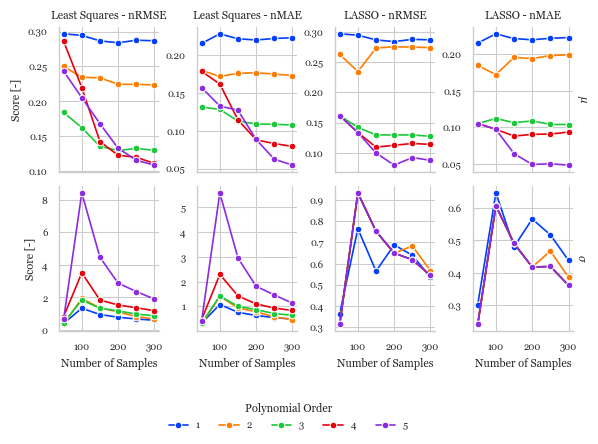

In [11]:
target = "Tower_Sdv"

dict_full_scores_la[target] = convergence_wrapper(target, poly_order_range, 'lasso_cv',
                                                sample_range, num_replications, 'val', df_train, df_test)
dict_full_scores_sq[target] = convergence_wrapper(target, poly_order_range, 'least_square',
                                                sample_range, num_replications, 'val', df_train, df_test)
create_custom_grid(dict_full_scores_sq[target], dict_full_scores_la[target], target)

#### PCE - $\ddot{x}_\text{tower,max}$

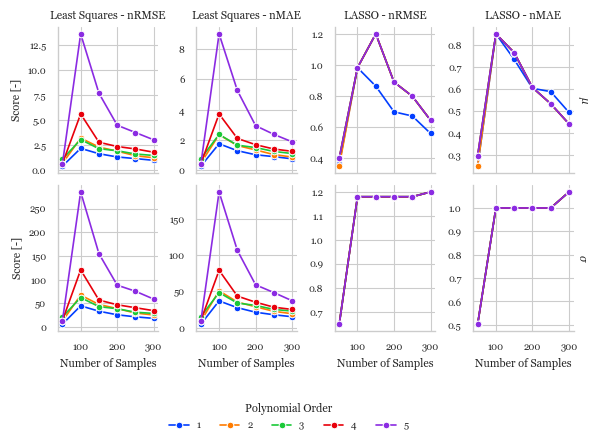

In [12]:
target = "Tower_Max"
dict_full_scores_la[target] = convergence_wrapper(target, poly_order_range, 'lasso_cv',
                                                   sample_range, num_replications, 'val', df_train, df_test)
dict_full_scores_sq[target] = convergence_wrapper(target, poly_order_range, 'least_square',
                                                   sample_range, num_replications, 'val', df_train, df_test)
create_custom_grid(dict_full_scores_sq[target], dict_full_scores_la[target], target)

## Model Generation
Here, the models are generated for the case study using 5th order polynomials and the LASSO regressor with all available training data. 

In [13]:
targets = ["Blade_Mean", "Blade_Max", "Tower_Sdv", "Tower_Max"]
model_orders = {"Blade_Mean": 5, "Blade_Max": 5,
                "Tower_Sdv": 5, "Tower_Max": 5}

pce_models = {target: dict.fromkeys(['mean', 'sdv']) for target in targets}
alpha_cv = {target: dict.fromkeys(['mean', 'sdv']) for target in targets}
final_alphas = {target: dict.fromkeys(['mean', 'sdv']) for target in targets}
scores = {target: dict.fromkeys(['mean', 'sdv']) for target in targets}

num_sampels = 300
num_replications = 30

df = load_sim_data(input_path_sim, 'casematrix.csv', 'surrogate_data.csv')
df_train = df.iloc[0:9000, :]
df_test = df.iloc[9000:, :]
dict_full_scores_cv = {}
dict_full_scores_val = {}

for target in targets:
    _, x_train_uniform, y_train_mean = get_training_data(
        df_train, num_sampels, num_replications, target, moment='mean')
    _, _, y_train_sdv = get_training_data(
        df_train, num_sampels, num_replications, target, moment='sdv')

    pce_models[target]['mean'], alpha_cv[target]['mean'], final_alphas[target]['mean'], _ = built_pce(
        x_train_uniform, y_train_mean, model_orders[target], 'lasso_cv')

    pce_models[target]['sdv'], alpha_cv[target]['sdv'], final_alphas[target]['sdv'], _ = built_pce(
        x_train_uniform, y_train_sdv, model_orders[target], 'lasso_cv')

    scores[target]['mean'] = validate_pce(
        pce_models[target]['mean'], df_test, target, 'mean')
    scores[target]['sdv'] = validate_pce(
        pce_models[target]['sdv'], df_test, target, 'sdv')

scores_table = display_scores_table(scores)
print(scores_table)

store_models(pce_models)

Metric      Target Moment  nMAE  nRMSE
0        Blade_Max   mean  0.07   0.08
1        Blade_Max    sdv  0.87   1.05
2       Blade_Mean   mean  0.02   0.03
3       Blade_Mean    sdv  0.13   0.17
4        Tower_Max   mean  0.44   0.64
5        Tower_Max    sdv  1.07   1.20
6        Tower_Sdv   mean  0.05   0.09
7        Tower_Sdv    sdv  0.36   0.54
